# Import packages

In [35]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json 
import re
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from keras.layers import Layer
from keras import backend as K
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy
from scipy.spatial.distance import cdist
import shap

from sklearn.model_selection import GridSearchCV
from dython.nominal import associations

# Load data

In [36]:
# Read the csv file
df = pd.read_csv('hotel_bookings.csv')

In [37]:
# Create date
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [38]:
# Define a dictionary mapping month names to numerical values
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month names to numerical values
df['arrival_date_month'] = df['arrival_date_month'].map(month_map)

# Create date
df['dateInt']=df['arrival_date_year'].astype(str) + df['arrival_date_month'].astype(str).str.zfill(2)+ df['arrival_date_day_of_month'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')
df = df.drop(columns=['dateInt'])

# Data Processing

## Data Leakage

In [39]:
# Data leakage columns removal
df = df.drop(columns=['country','assigned_room_type','days_in_waiting_list'])

## Missing Data Analysis

In [40]:
# Count the number of missing values for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing data for each feature
percentage_missing = (missing_values / len(df)) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Number of Missing Values': missing_values, 'Percentage': percentage_missing})

# Sort the DataFrame by percentage missing in descending order
missing_data_info = missing_data_info.sort_values(by='Percentage', ascending=False)

missing_data_info

,Number of Missing Values,Percentage
company,112593,94.306893
agent,16340,13.686238
children,4,0.003350
hotel,0,0.000000
previous_cancellations,0,0.000000
reservation_status_date,0,0.000000
reservation_status,0,0.000000
total_of_special_requests,0,0.000000
required_car_parking_spaces,0,0.000000
adr,0,0.000000


In [41]:
# Missing data imputation
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Children and company both fillna with 0
df = df.dropna()
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,No Deposit,0.0,0.0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,No Deposit,0.0,0.0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,No Deposit,0.0,0.0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,No Deposit,304.0,0.0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,No Deposit,240.0,0.0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,8,35,30,2,5,2,...,No Deposit,394.0,0.0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,0,102,2017,8,35,31,2,5,3,...,No Deposit,9.0,0.0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,0,34,2017,8,35,31,2,5,2,...,No Deposit,9.0,0.0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,0,109,2017,8,35,31,2,5,2,...,No Deposit,89.0,0.0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


## Outlier Analysis

In [42]:
# Outlier analysis
index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']



for i, col in enumerate(index):
    
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Show outliers
    print(col, df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0],round((df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0])/df.shape[0]*100,2))

adr 3793 3.18
adults 29709 24.88
babies 917 0.77
arrival_date_day_of_month 0 0.0
arrival_date_week_number 0 0.0
arrival_date_year 0 0.0
booking_changes 18076 15.14
children 8590 7.2
lead_time 3005 2.52
previous_bookings_not_canceled 3620 3.03
previous_cancellations 6484 5.43
required_car_parking_spaces 7416 6.21
stays_in_weekend_nights 265 0.22
stays_in_week_nights 3354 2.81
total_of_special_requests 2877 2.41


In [43]:
import pandas as pd

# Assuming you have already calculated Q1, Q3, IQR, lower_bound, and upper_bound as you did in your code snippet

index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

outlier_data = []

for col in index:
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outlier_count = df.shape[0] - df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0]
    outlier_percent = round((outlier_count / df.shape[0]) * 100, 2)
    
    # Append data to list
    outlier_data.append([col, outlier_count, outlier_percent])
    
    

# Create dataframe
outlier_df = pd.merge(pd.DataFrame(outlier_data, columns=['Feature', 'Outlier Count', 'Outlier Percentage']),df[index].describe().T.rename_axis("Feature"),on ='Feature',how='left')

outlier_df.sort_values(by = 'Outlier Percentage', ascending = False)

,Feature,Outlier Count,Outlier Percentage,count,mean,std,min,25%,50%,75%,max
1,adults,29709,24.88,119386.0,1.856390,0.579261,0.00,2.00,2.00,2.0,55.0
6,booking_changes,18076,15.14,119386.0,0.221131,0.652315,0.00,0.00,0.00,0.0,21.0
7,children,8590,7.20,119386.0,0.103890,0.398561,0.00,0.00,0.00,0.0,10.0
11,required_car_parking_spaces,7416,6.21,119386.0,0.062520,0.245295,0.00,0.00,0.00,0.0,8.0
10,previous_cancellations,6484,5.43,119386.0,0.087121,0.844350,0.00,0.00,0.00,0.0,26.0
9,previous_bookings_not_canceled,3620,3.03,119386.0,0.137102,1.497462,0.00,0.00,0.00,0.0,72.0
13,stays_in_week_nights,1438,1.20,119386.0,2.500310,1.908289,0.00,1.00,2.00,3.0,50.0
2,babies,917,0.77,119386.0,0.007949,0.097438,0.00,0.00,0.00,0.0,10.0
0,adr,327,0.27,119386.0,101.833541,50.534664,-6.38,69.29,94.59,126.0,5400.0
8,lead_time,181,0.15,119386.0,104.014801,106.863286,0.00,18.00,69.00,160.0,737.0


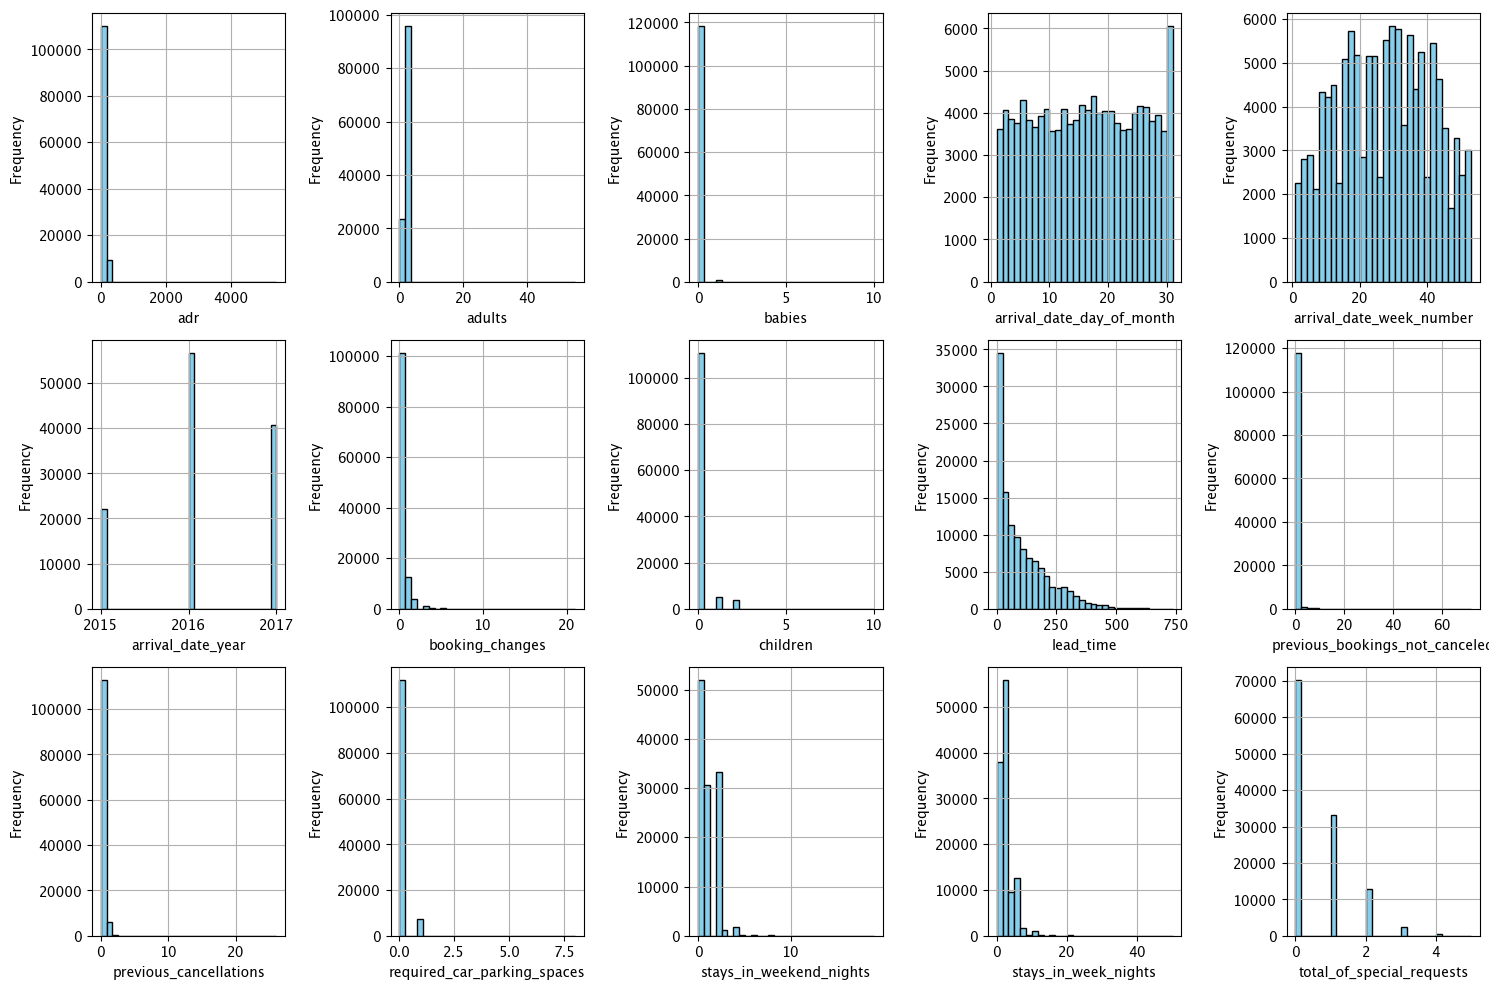

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import math


index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create histograms for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

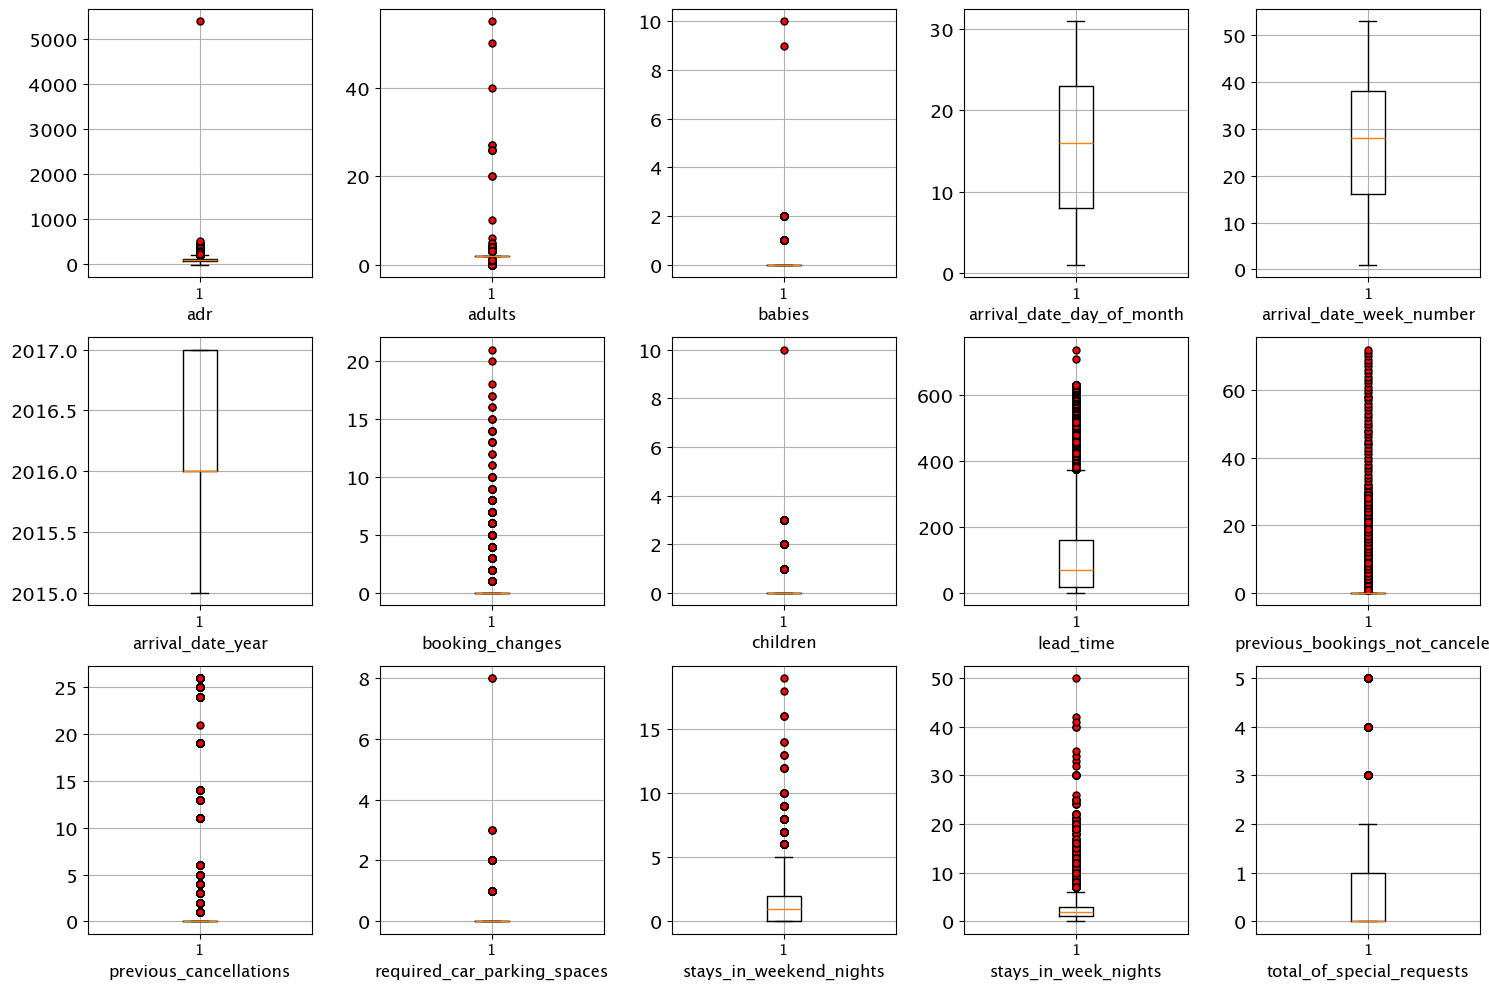

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import math


index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create boxplots for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.boxplot(df[column], vert=True, flierprops=dict(marker='o', markersize=5, linestyle='none', markerfacecolor='red'))
    ax.set_xlabel(column, fontsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


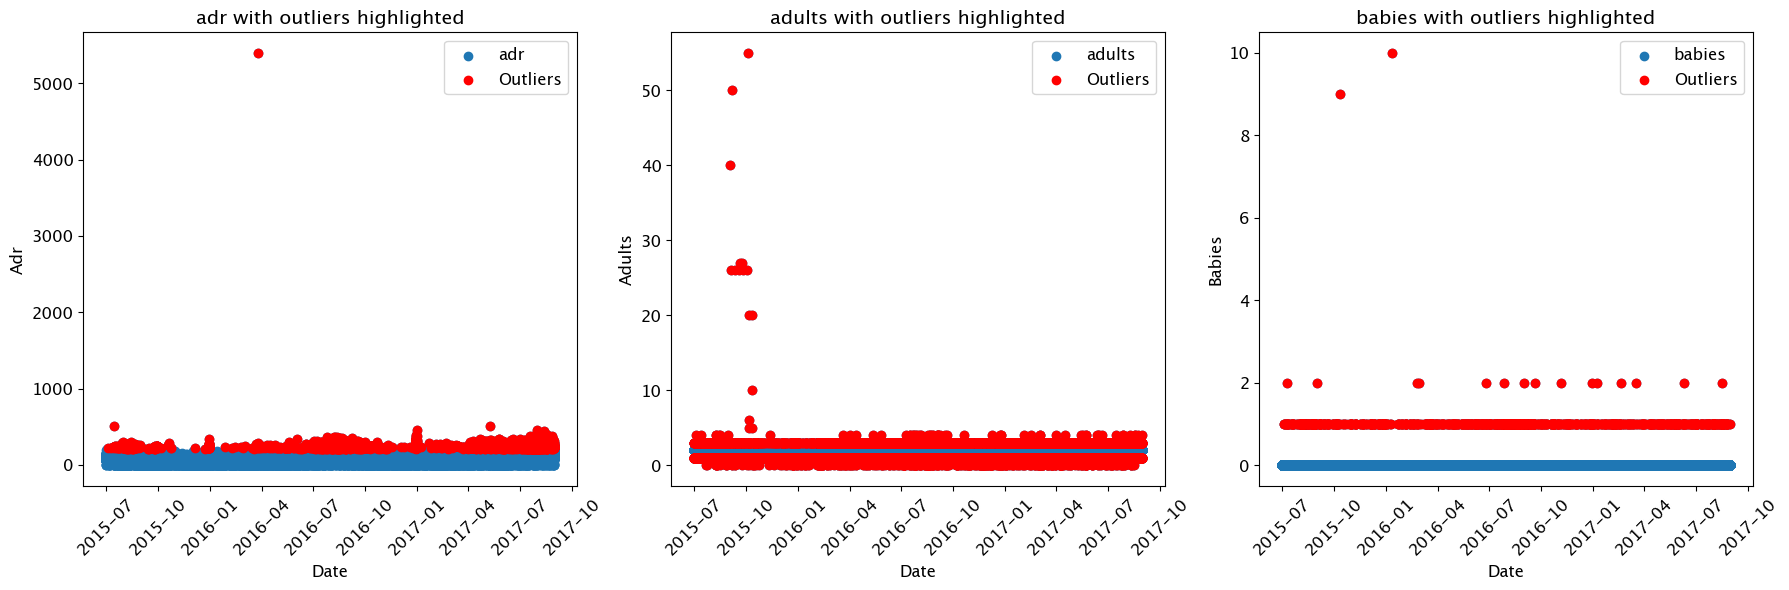

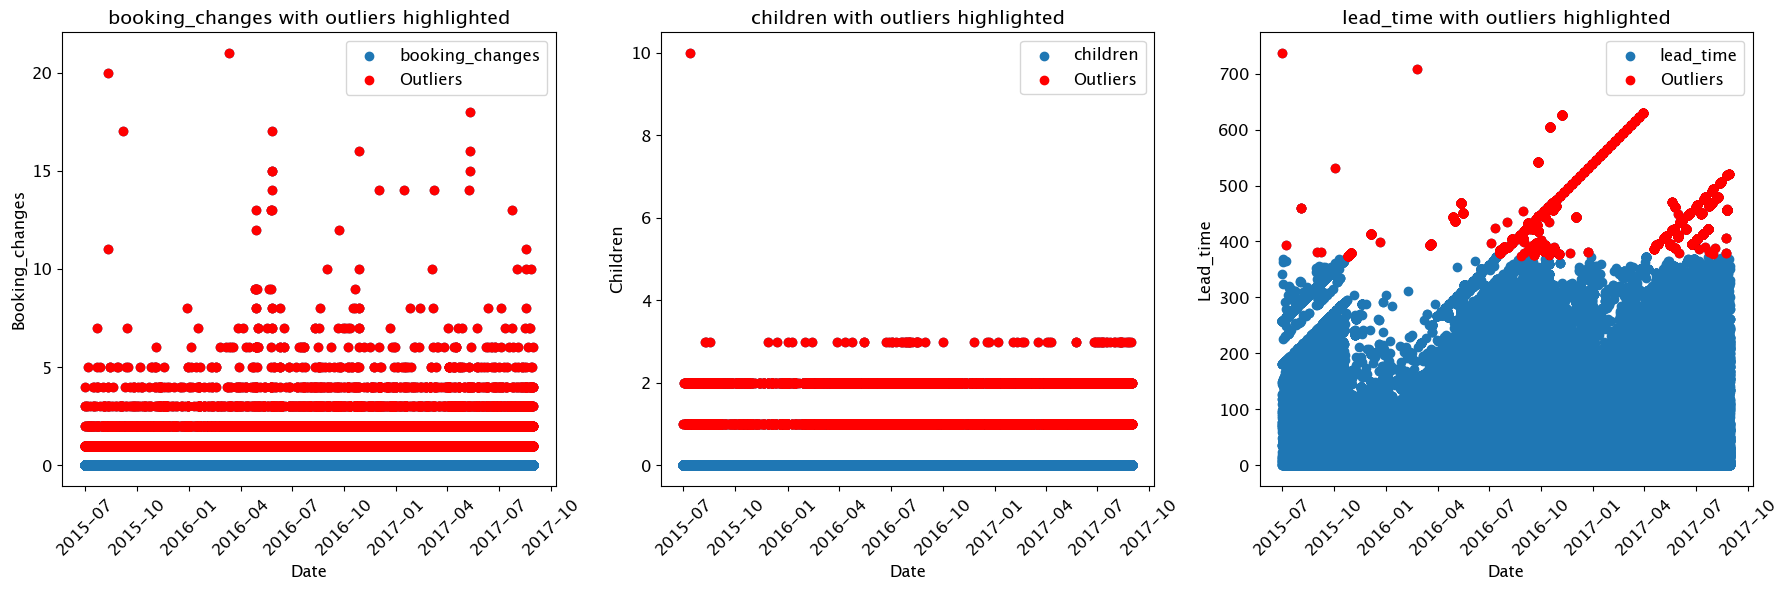

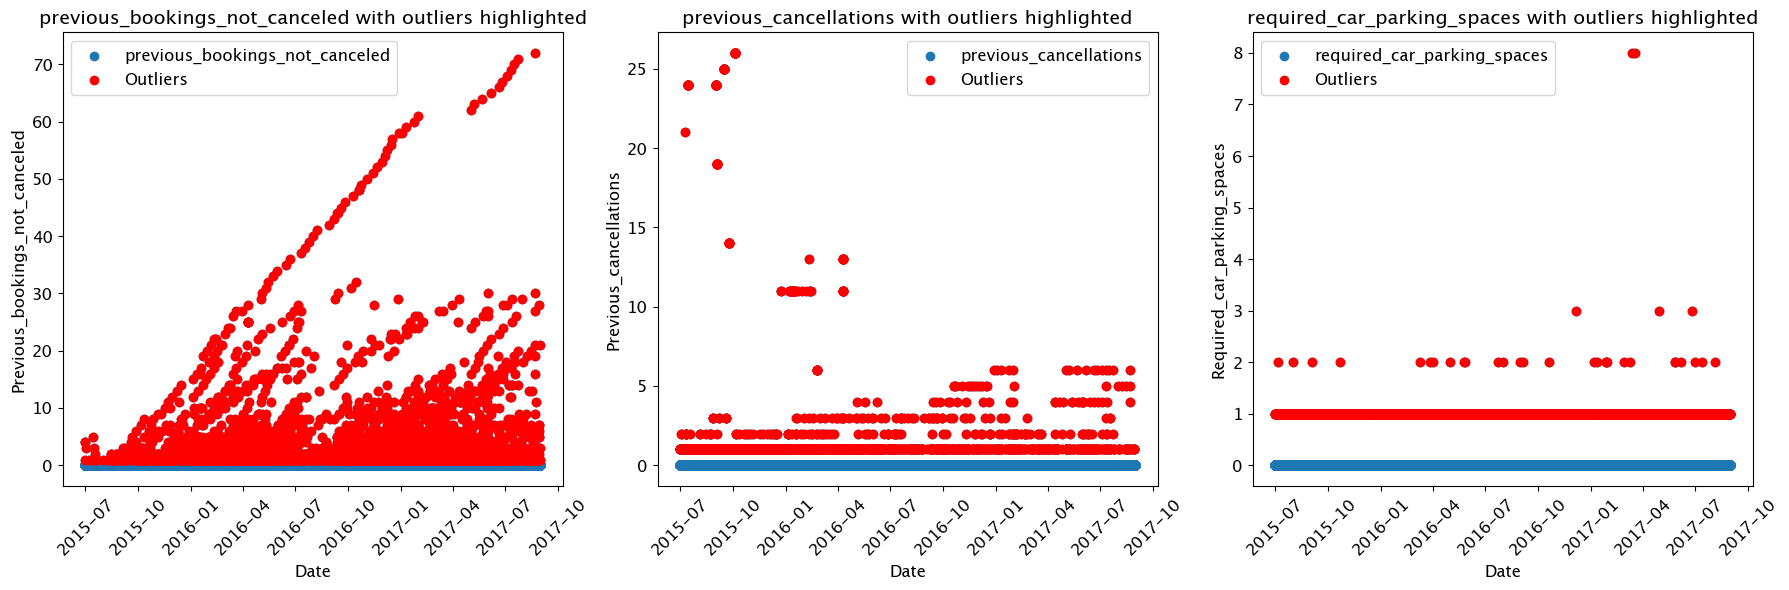

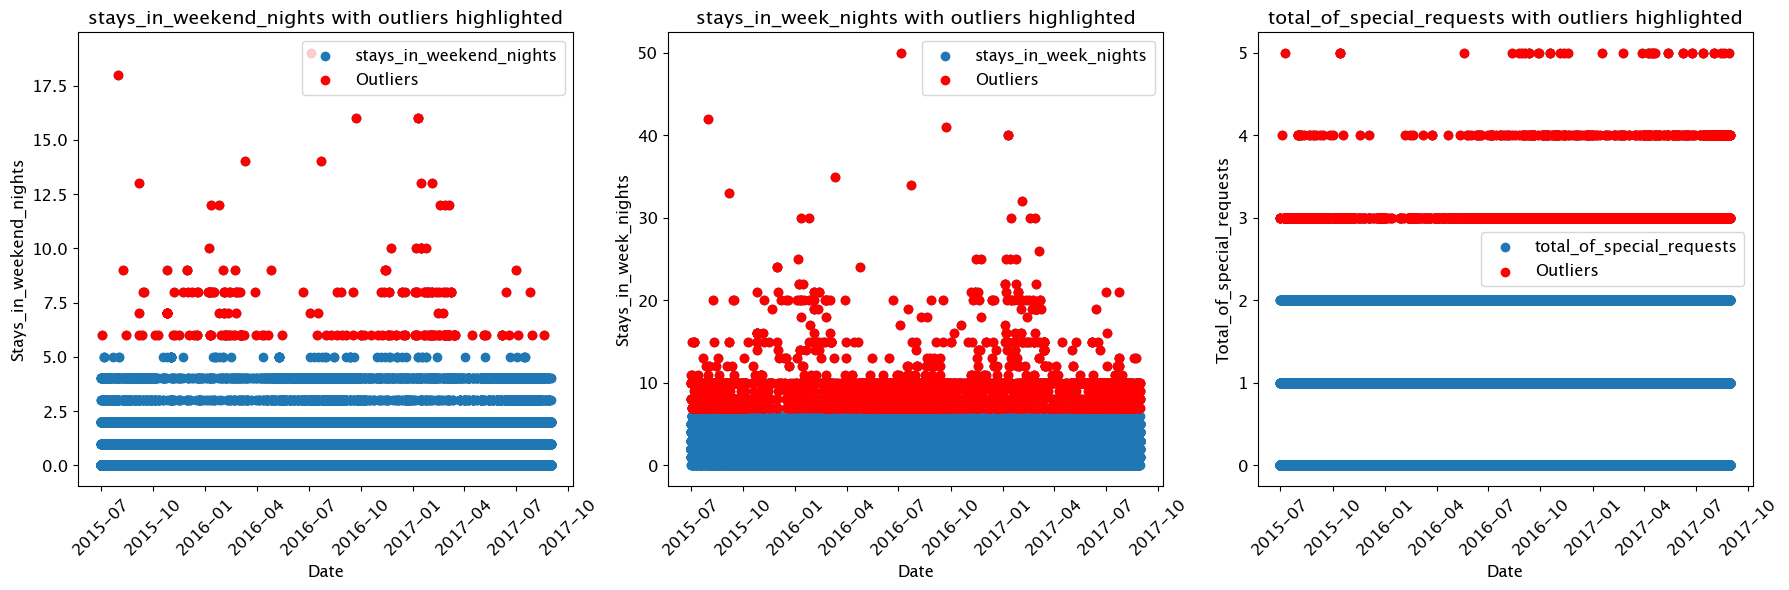

In [46]:
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows needed
num_rows = int(np.ceil(len(index) / 3))

# Iterate through the indices and create plots
for i in range(num_rows):
    # Create a subplot with three columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each index in the current row
    for j in range(3):
        idx = i * 3 + j
        if idx < len(index):
            col = index[idx]
            # Calculate outliers
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            # Plotting
            axes[j].scatter(df['date'], df[col], label=col)
            axes[j].scatter(outliers['date'], outliers[col], color='red', label='Outliers')

            # Formatting
            axes[j].set_title(f'{col} with outliers highlighted', fontsize=14)
            axes[j].set_xlabel('Date',fontsize=12)
            axes[j].set_ylabel(col.capitalize(),fontsize=12)
            axes[j].tick_params(axis='x', labelsize=12,rotation=45)  # Set x-axis tick label fontsize
            axes[j].tick_params(axis='y', labelsize=12)  # Set y-axis tick label fontsize
            axes[j].legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Remove numeric and categorical outliers

In [47]:
# Numeric
df = df[df['adr'] <5000]

# Feature Enginnering

In [48]:
df['sum_of_weekend_nights_and_week_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']  
df['interaction_nights_and_adr'] = df['sum_of_weekend_nights_and_week_nights'] * df['adr']  
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,0.0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0,0.00
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,0.0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0,0.00
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,0.0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1,75.00
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,0.0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1,75.00
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,0.0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2,196.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,8,35,30,2,5,2,...,0.0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30,7,672.98
119386,City Hotel,0,102,2017,8,35,31,2,5,3,...,0.0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31,7,1578.01
119387,City Hotel,0,34,2017,8,35,31,2,5,2,...,0.0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31,7,1103.97
119388,City Hotel,0,109,2017,8,35,31,2,5,2,...,0.0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31,7,730.80


# Filtering customers

In [49]:
df = df[df['reservation_status_date'] >= df['date']]

# Load weather data

In [51]:
# Import data
df_wea = pd.read_csv('weather_data_2015_2017.csv')
df_wea = df_wea[['mintempC','maxtempC','avgtempC','date','Hotel']]
df_wea.rename(columns={'Hotel': 'hotel'}, inplace=True)
df_wea['date'] = pd.to_datetime(df_wea['date'])
df_wea

,mintempC,maxtempC,avgtempC,date,hotel
0,17,23,20,2015-07-01,City Hotel
1,16,24,20,2015-07-02,City Hotel
2,15,25,20,2015-07-03,City Hotel
3,17,27,22,2015-07-04,City Hotel
4,17,26,21,2015-07-05,City Hotel
...,...,...,...,...,...
1581,20,26,23,2017-08-27,Resort Hotel
1582,19,23,21,2017-08-28,Resort Hotel
1583,19,24,21,2017-08-29,Resort Hotel
1584,20,26,23,2017-08-30,Resort Hotel


In [52]:
# Combine data
df = pd.merge(df, df_wea,on=['date','hotel'],how='left')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,mintempC,maxtempC,avgtempC
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,0,0,Check-Out,2015-07-01,2015-07-01,0,0.00,19,25,22
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,0,0,Check-Out,2015-07-01,2015-07-01,0,0.00,19,25,22
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,0,0,Check-Out,2015-07-02,2015-07-01,1,75.00,19,25,22
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,0,0,Check-Out,2015-07-02,2015-07-01,1,75.00,19,25,22
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,0,1,Check-Out,2015-07-03,2015-07-01,2,196.00,19,25,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77248,City Hotel,0,23,2017,8,35,30,2,5,2,...,0,0,Check-Out,2017-09-06,2017-08-30,7,672.98,17,25,21
77249,City Hotel,0,102,2017,8,35,31,2,5,3,...,0,2,Check-Out,2017-09-07,2017-08-31,7,1578.01,17,27,21
77250,City Hotel,0,34,2017,8,35,31,2,5,2,...,0,4,Check-Out,2017-09-07,2017-08-31,7,1103.97,17,27,21
77251,City Hotel,0,109,2017,8,35,31,2,5,2,...,0,0,Check-Out,2017-09-07,2017-08-31,7,730.80,17,27,21


In [54]:
df.drop(columns=['mintempC','maxtempC','reservation_status_date','reservation_status'], inplace = True)

# EDA

<Figure size 1200x600 with 0 Axes>

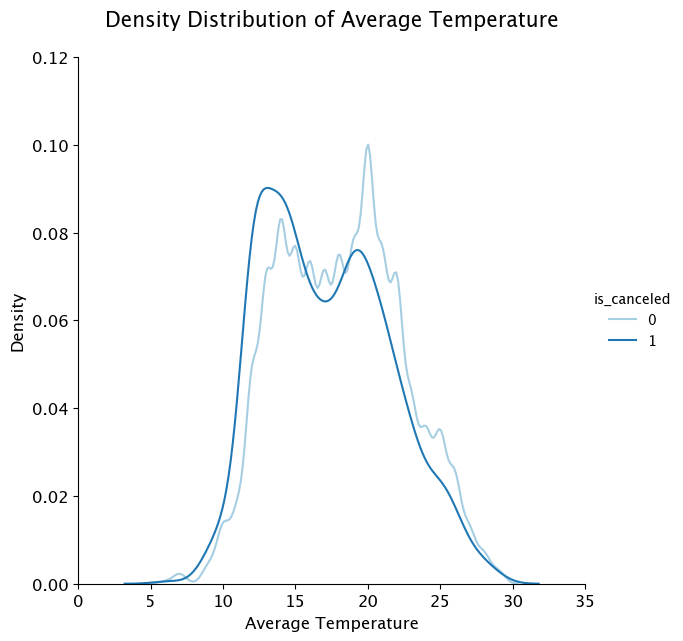

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe and 'x' is the column containing continuous values,
# and 'iscancelled' is the column based on which you want to categorize the data
plt.figure(figsize=(12, 6))

# Create a FacetGrid with seaborn
g = sns.FacetGrid(df, hue="is_canceled", palette="Paired", height=6)

# Map the KDE plot on the FacetGrid
g.map(sns.kdeplot, 'avgtempC', bw_adjust=1)

# Set x-axis limits
plt.xlim(0)

# Set titles and labels
g.set_axis_labels("avgtempC", "Density", fontsize=12)

# Add legend
g.add_legend()

# Set titles and labels
g.set_axis_labels("Average Temperature", "Density")
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
plt.title('Density Distribution of Average Temperature',fontsize=15, pad=22)
plt.show()